# Team Stats: Persistence and Predictability

- Step one; rank the team stats by their persistence.
- Step two; of the persistent team stats, rank them by their predictiveness of point spread and MOV.

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## Single Season Example

In [3]:
df = pd.read_csv('../data/nba_stats/2018-19_teamgamelogs_Base.csv')

In [20]:
features_of_interest = [
    'ft_pct', 'fg_pct', 'fg3_pct'
]

Per season, get R^2 for mean/median for even/odd and first/second half by team.

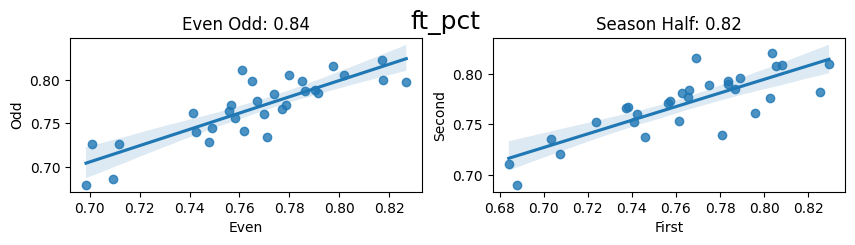

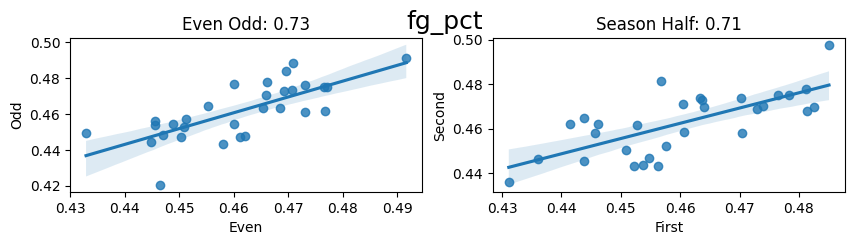

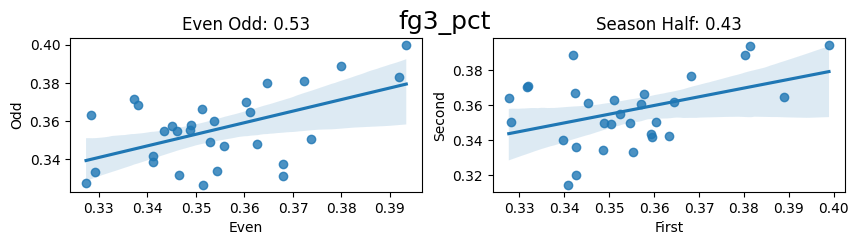

In [74]:
for feature in features_of_interest:
    
    data = (
        df
        .sort_values(
            by=['team_abbreviation', 'game_date']
        )
        .assign(
            game_rank = lambda x: x.groupby('team_abbreviation')['game_id'].rank(),
            even_odd = lambda x: x['game_rank'].transform(lambda s: 'Even' if s % 2 == 0 else 'Odd'),
            season_half = lambda x: x['game_rank'].transform(lambda s: 'First' if s <= 41 else 'Second')
        )
    )

    even_odd = (
        data
        .groupby(['team_abbreviation', 'even_odd'])
        .agg(
            average = (feature, 'mean')
        )
        .reset_index()
        .pivot_table(
            index='team_abbreviation',
            columns='even_odd',
            values='average'
        )
        .reset_index()
    )

    season_half = (
        data
        .groupby(['team_abbreviation', 'season_half'])
        .agg(
            average = (feature, 'mean')
        )
        .reset_index()
        .pivot_table(
            index='team_abbreviation',
            columns='season_half',
            values='average'
        )
        .reset_index()
    )

    season_half.head()

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 2))

    sns.regplot(
        data=even_odd,
        x='Even',
        y='Odd',
        ax=ax1
    )

    even_odd_correlation = round(float(even_odd.corr().min().min()),2)

    ax1.set_title(f'Even Odd: {even_odd_correlation}')

    sns.regplot(
        data=season_half,
        x='First',
        y='Second',
        ax=ax2
    )

    season_half_correlation = round(float(season_half.corr().min().min()),2)

    ax1.set_title(f'Even Odd: {even_odd_correlation}')
    ax2.set_title(f'Season Half: {season_half_correlation}')

    plt.suptitle(f'{feature}', size=18, y=1.02)

    plt.show()

## All Seasons: Base

In [80]:
data = (
    df
    .sort_values(
        by=['team_abbreviation', 'game_date']
    )
    .assign(
        game_rank = lambda x: x.groupby('team_abbreviation')['game_id'].rank(),
        even_odd = lambda x: x['game_rank'].transform(lambda s: 'Even' if s % 2 == 0 else 'Odd'),
        season_half = lambda x: x['game_rank'].transform(lambda s: 'First' if s <= 41 else 'Second')
    )
)

(
    data
    .groupby(['season_year', 'team_abbreviation', 'even_odd'])
    .agg(
        average = (feature, 'mean')
    )
    .reset_index()
    .pivot_table(
        index=['season_year', 'team_abbreviation'],
        columns='even_odd',
        values='average'
    )
    .reset_index()
    .groupby(['season_year'])
    .corr()
)

even_odd                 Even      Odd
season_year even_odd                  
2018-19     Even      1.00000  0.53141
            Odd       0.53141  1.00000

In [96]:
data_location = '../data/nba_stats/'

files = [
    x for x in os.listdir(data_location)
    if 'Base' in x
]

dfs = []

for file in files:
    df = pd.read_csv(data_location + file)
    dfs.append(df)
    
base_logs = pd.concat(dfs)

In [131]:
subsets = []

for feature in features_of_interest:

    data = (
        base_logs
        .sort_values(
            by=['season_year', 'team_abbreviation', 'game_id']
        )
         .assign(
            game_rank = lambda x: x.groupby(['season_year', 'team_abbreviation'])['game_id'].rank(),
            even_odd = lambda x: x['game_rank'].transform(lambda s: 'Even' if s % 2 == 0 else 'Odd'),
            season_half = lambda x: x['game_rank'].transform(lambda s: 'First' if s <= 41 else 'Second')
        )
        .melt(
            id_vars=['season_year', 'team_abbreviation', 'game_rank', 'even_odd', 'season_half'],
            value_vars=feature,
            value_name=feature
        )
    )

    even_odd = (
        data
        .pivot_table(
            index=['season_year', 'team_abbreviation'],
            columns='even_odd',
            values=feature
        )
        .reset_index()
        .groupby('season_year')
        .corr()
        .reset_index()
        .query('even_odd == "Odd"')
        .assign(
            feature=feature,
            method='Even Odd',
            correlation= lambda x: x['Even']
        )
        [['season_year', 'feature', 'method', 'correlation']]
    )

    season_half = (
        data
        .pivot_table(
            index=['season_year', 'team_abbreviation'],
            columns='season_half',
            values=feature
        )
        .reset_index()
        .groupby('season_year')
        .corr()
        .reset_index()
        .query('season_half == "First"')
        .assign(
            feature=feature,
            method='Season Half',
            correlation= lambda x: x['Second']
        )
        [['season_year', 'feature', 'method', 'correlation']]
    )

    subsets.append(season_half)
    subsets.append(even_odd)

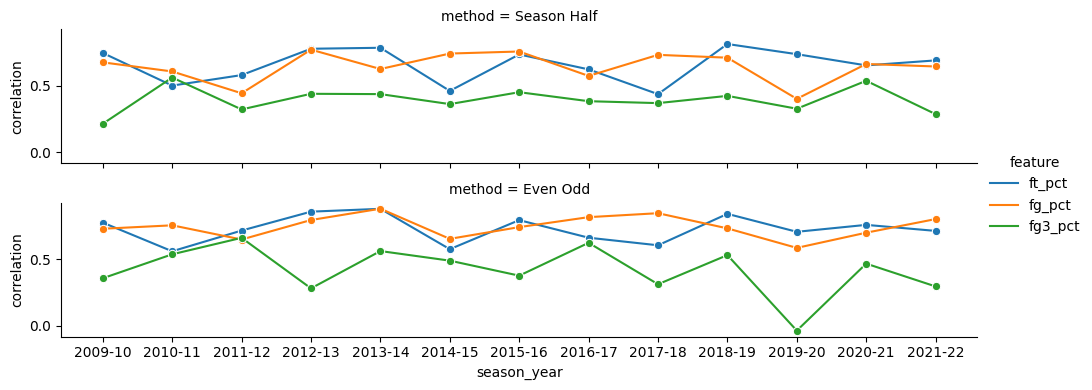

In [139]:
sns.relplot(
    data=pd.concat(subsets).query('season_year != "2022-23"'),
    x='season_year',
    y='correlation',
    col='method',
    hue='feature',
    marker='o',
    kind='line',
    col_wrap=1,
    height=2,
    aspect=5
)

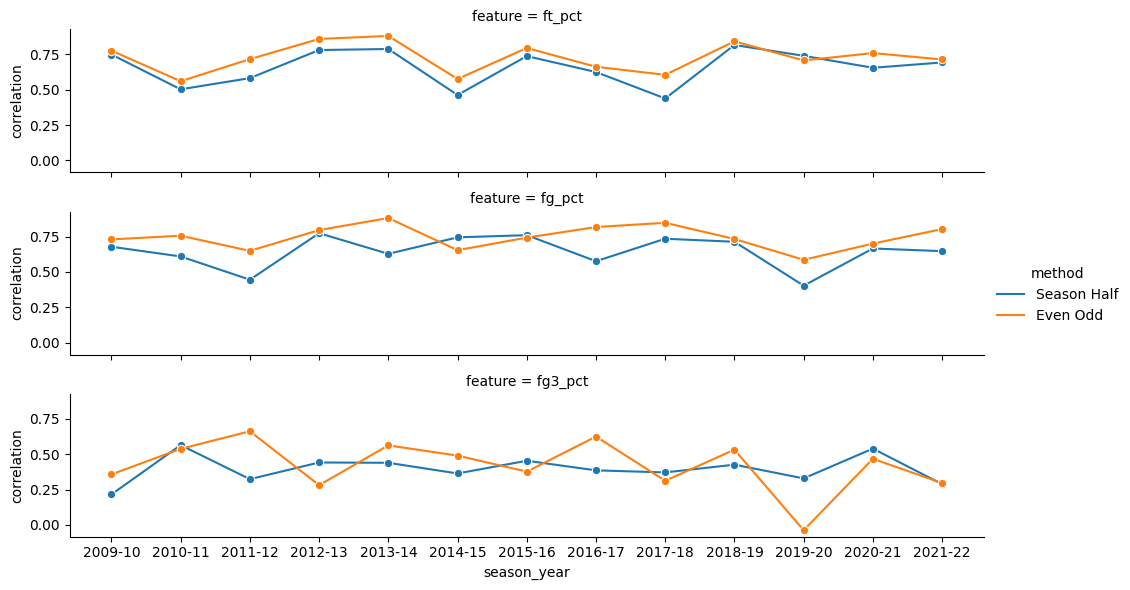

In [140]:
sns.relplot(
    data=pd.concat(subsets).query('season_year != "2022-23"'),
    x='season_year',
    y='correlation',
    col='feature',
    hue='method',
    marker='o',
    kind='line',
    col_wrap=1,
    height=2,
    aspect=5
)

Three Observations:

- Even odd is more persistent than first/second half of season. 
- The covid year was the least persistent
- 3p Percentage is the least persistent.

## Advanced

In [141]:
df = pd.read_csv('../data/nba_stats/2018-19_teamgamelogs_Advanced.csv')

In [145]:
features_of_interest = [
    'e_off_rating', 'off_rating', 'e_def_rating', 'def_rating', 'e_net_rating', 'net_rating', 'ast_pct',
    'ast_to', 'ast_ratio', 'oreb_pct', 'dreb_pct', 'reb_pct', 'tm_tov_pct'
]

In [148]:
data_location = '../data/nba_stats/'

files = [
    x for x in os.listdir(data_location)
    if 'Advanced' in x
]

dfs = []

for file in files:
    df = pd.read_csv(data_location + file)
    dfs.append(df)
    
logs = pd.concat(dfs)

subsets = []

for feature in features_of_interest:

    data = (
        logs
        .sort_values(
            by=['season_year', 'team_abbreviation', 'game_id']
        )
         .assign(
            game_rank = lambda x: x.groupby(['season_year', 'team_abbreviation'])['game_id'].rank(),
            even_odd = lambda x: x['game_rank'].transform(lambda s: 'Even' if s % 2 == 0 else 'Odd'),
            season_half = lambda x: x['game_rank'].transform(lambda s: 'First' if s <= 41 else 'Second')
        )
        .melt(
            id_vars=['season_year', 'team_abbreviation', 'game_rank', 'even_odd', 'season_half'],
            value_vars=feature,
            value_name=feature
        )
    )

    even_odd = (
        data
        .pivot_table(
            index=['season_year', 'team_abbreviation'],
            columns='even_odd',
            values=feature
        )
        .reset_index()
        .groupby('season_year')
        .corr()
        .reset_index()
        .query('even_odd == "Odd"')
        .assign(
            feature=feature,
            method='Even Odd',
            correlation= lambda x: x['Even']
        )
        [['season_year', 'feature', 'method', 'correlation']]
    )

    season_half = (
        data
        .pivot_table(
            index=['season_year', 'team_abbreviation'],
            columns='season_half',
            values=feature
        )
        .reset_index()
        .groupby('season_year')
        .corr()
        .reset_index()
        .query('season_half == "First"')
        .assign(
            feature=feature,
            method='Season Half',
            correlation= lambda x: x['Second']
        )
        [['season_year', 'feature', 'method', 'correlation']]
    )

    subsets.append(season_half)
    subsets.append(even_odd)

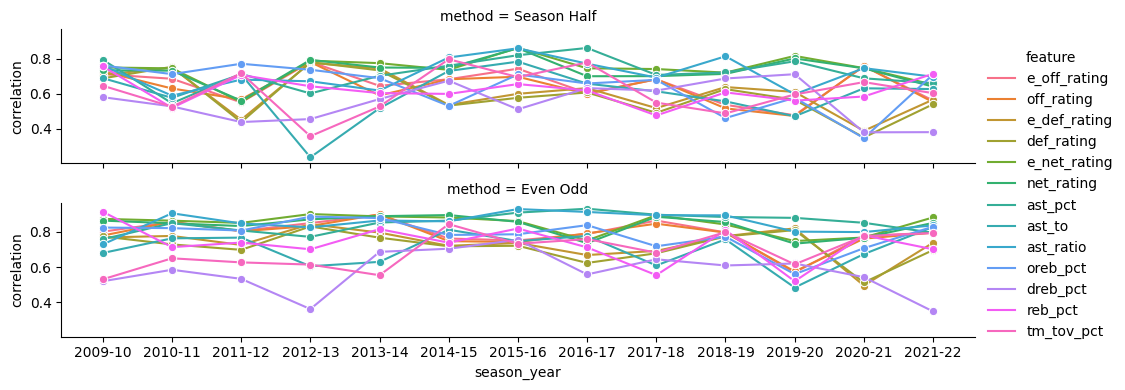

In [149]:
sns.relplot(
    data=pd.concat(subsets).query('season_year != "2022-23"'),
    x='season_year',
    y='correlation',
    col='method',
    hue='feature',
    marker='o',
    kind='line',
    col_wrap=1,
    height=2,
    aspect=5
)

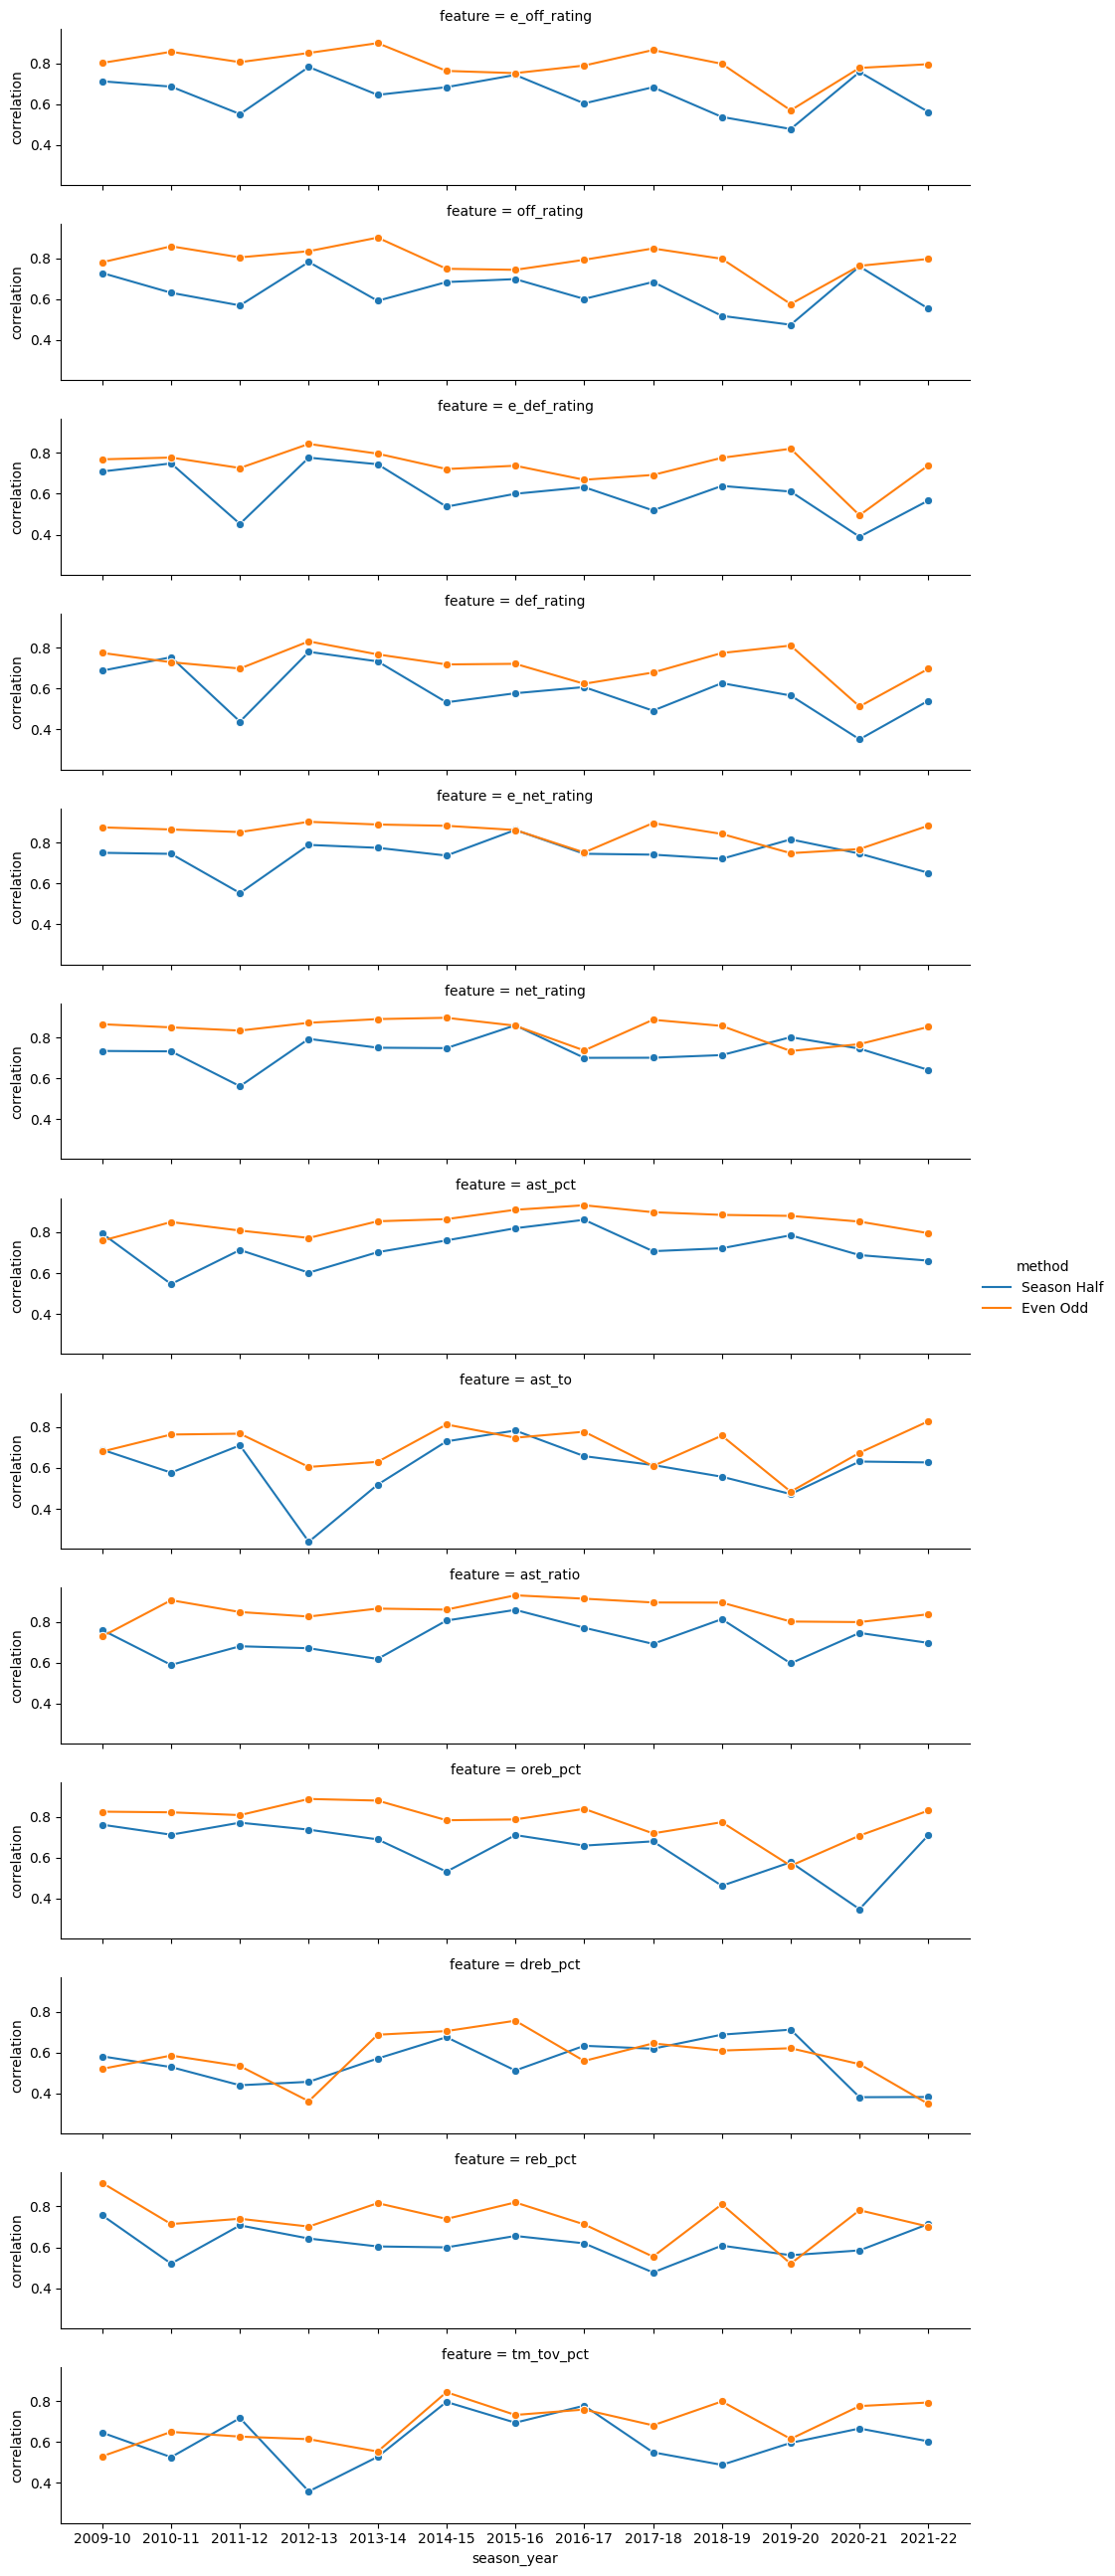

In [150]:
sns.relplot(
    data=pd.concat(subsets).query('season_year != "2022-23"'),
    x='season_year',
    y='correlation',
    col='feature',
    hue='method',
    marker='o',
    kind='line',
    col_wrap=1,
    height=2,
    aspect=5
)

These are much better than the base scores.

## Four Factors

In [151]:
df = pd.read_csv('../data/nba_stats/2018-19_teamgamelogs_Four Factors.csv')

In [153]:
features_of_interest = [
    'efg_pct',
 'fta_rate',
 'tm_tov_pct',
 'oreb_pct',
 'opp_efg_pct',
 'opp_fta_rate',
 'opp_tov_pct',
 'opp_oreb_pct',
]

In [154]:
data_location = '../data/nba_stats/'

files = [
    x for x in os.listdir(data_location)
    if 'Four Factors' in x
]

dfs = []

for file in files:
    df = pd.read_csv(data_location + file)
    dfs.append(df)
    
logs = pd.concat(dfs)

subsets = []

for feature in features_of_interest:

    data = (
        logs
        .sort_values(
            by=['season_year', 'team_abbreviation', 'game_id']
        )
         .assign(
            game_rank = lambda x: x.groupby(['season_year', 'team_abbreviation'])['game_id'].rank(),
            even_odd = lambda x: x['game_rank'].transform(lambda s: 'Even' if s % 2 == 0 else 'Odd'),
            season_half = lambda x: x['game_rank'].transform(lambda s: 'First' if s <= 41 else 'Second')
        )
        .melt(
            id_vars=['season_year', 'team_abbreviation', 'game_rank', 'even_odd', 'season_half'],
            value_vars=feature,
            value_name=feature
        )
    )

    even_odd = (
        data
        .pivot_table(
            index=['season_year', 'team_abbreviation'],
            columns='even_odd',
            values=feature
        )
        .reset_index()
        .groupby('season_year')
        .corr()
        .reset_index()
        .query('even_odd == "Odd"')
        .assign(
            feature=feature,
            method='Even Odd',
            correlation= lambda x: x['Even']
        )
        [['season_year', 'feature', 'method', 'correlation']]
    )

    season_half = (
        data
        .pivot_table(
            index=['season_year', 'team_abbreviation'],
            columns='season_half',
            values=feature
        )
        .reset_index()
        .groupby('season_year')
        .corr()
        .reset_index()
        .query('season_half == "First"')
        .assign(
            feature=feature,
            method='Season Half',
            correlation= lambda x: x['Second']
        )
        [['season_year', 'feature', 'method', 'correlation']]
    )

    subsets.append(season_half)
    subsets.append(even_odd)

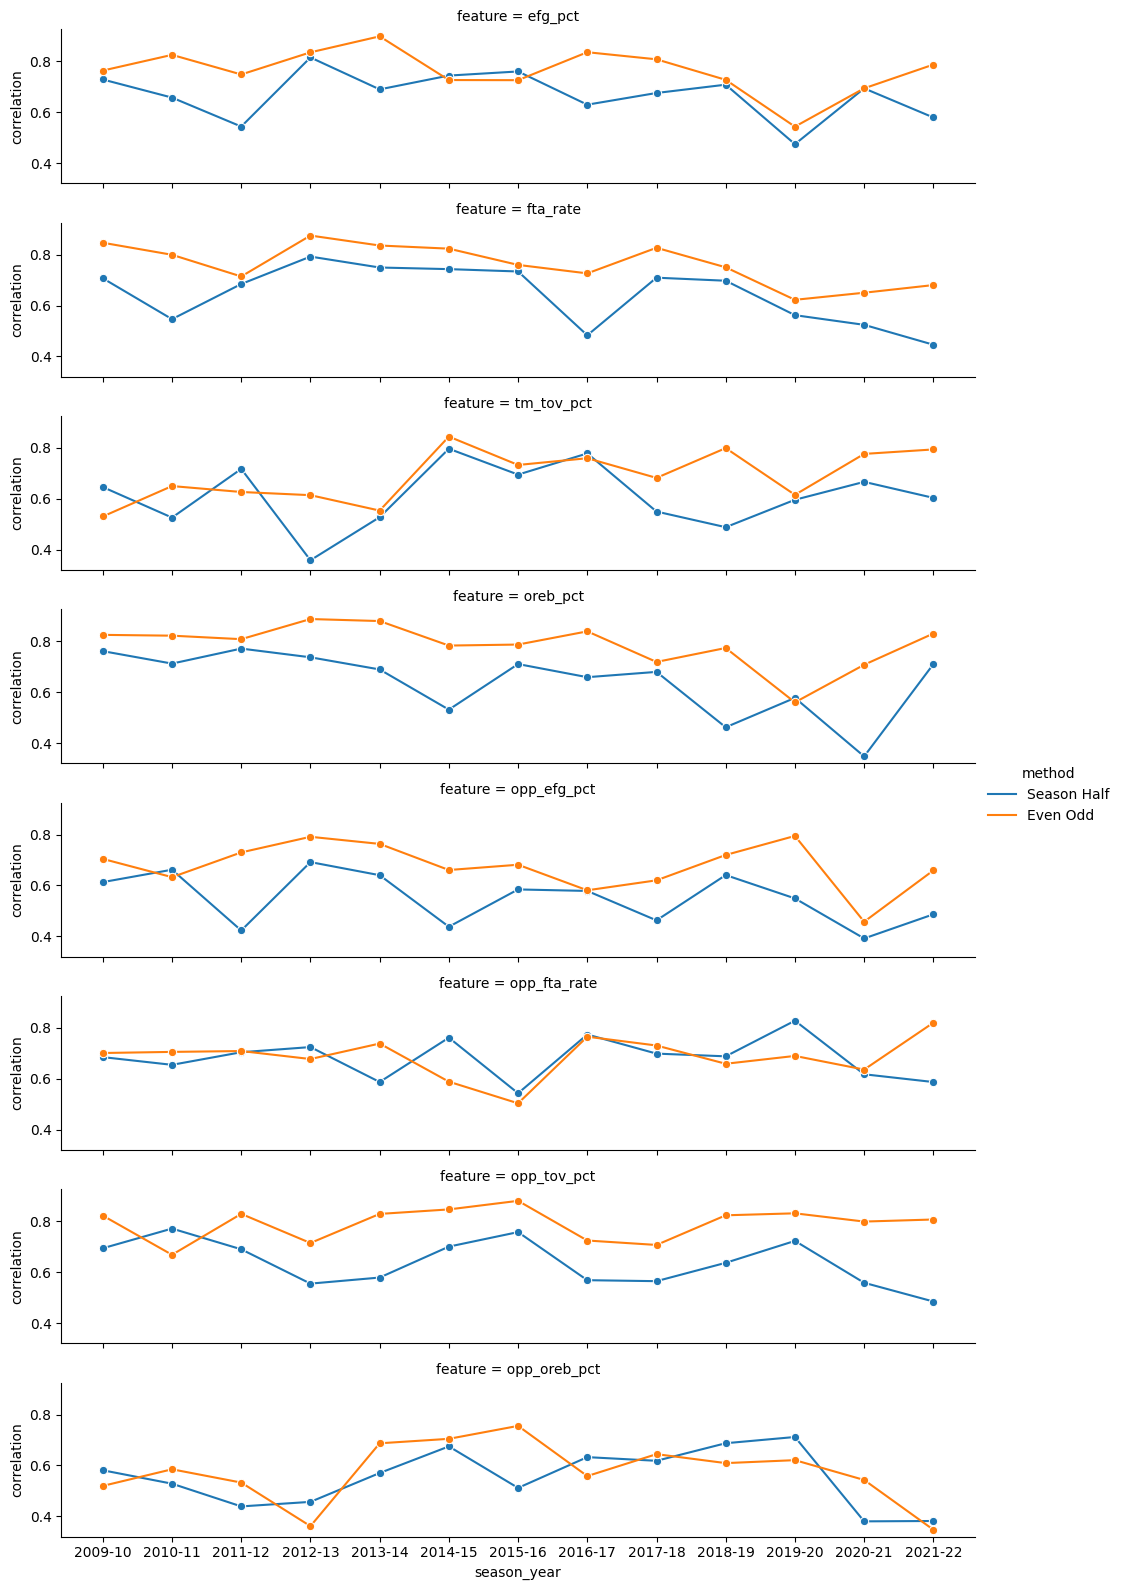

In [155]:
sns.relplot(
    data=pd.concat(subsets).query('season_year != "2022-23"'),
    x='season_year',
    y='correlation',
    col='feature',
    hue='method',
    marker='o',
    kind='line',
    col_wrap=1,
    height=2,
    aspect=5
)

Also very good.

## MISC

In [156]:
df = pd.read_csv('../data/nba_stats/2018-19_teamgamelogs_Misc.csv')

In [157]:
df.columns.tolist()

['season_year',
 'team_id',
 'team_abbreviation',
 'team_name',
 'game_id',
 'game_date',
 'matchup',
 'wl',
 'min',
 'pts_off_tov',
 'pts_2nd_chance',
 'pts_fb',
 'pts_paint',
 'opp_pts_off_tov',
 'opp_pts_2nd_chance',
 'opp_pts_fb',
 'opp_pts_paint',
 'gp_rank',
 'w_rank',
 'l_rank',
 'w_pct_rank',
 'min_rank',
 'pts_off_tov_rank',
 'pts_2nd_chance_rank',
 'pts_fb_rank',
 'pts_paint_rank',
 'opp_pts_off_tov_rank',
 'opp_pts_2nd_chance_rank',
 'opp_pts_fb_rank',
 'opp_pts_paint_rank',
 'endpoint',
 'input_season',
 'input_measure']

No rates.

## Team ID Mapping to Lines

In [160]:
data_location = '../data/nba_stats/'

files = [
    x for x in os.listdir(data_location)
    if 'Base' in x
]

dfs = []

for file in files:
    df = pd.read_csv(data_location + file)
    dfs.append(df)
    
base_logs = pd.concat(dfs)

(
    base_logs
    [['team_id', 'team_name']]
    .drop_duplicates()
    .sort_values(
        by='team_id'
    )
    .to_clipboard()
)